# Лабораторная работа №2

## Условие

Вариант №9

Аппроксимируемая функция:

$$ e^{-x^2} \cdot \cos{10x} $$

Диапазон изменения входной переменной: `[-3; 3]`

Объем выборки: `200`

Режим обучение: `Stochastic`

## Импорты

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, max_error
from time import time
from tqdm import tqdm
from torchview import draw_graph  # рендер схемы нейронной сети

В данном курсе особо не будем запариваться над переносом на GPU, так как мы не будем использовать глубокие нейросети, и разница во времени работы будет не столь большая

## Определения

In [139]:
torch.random.manual_seed(int(time()))

plt.style.use("seaborn-v0_8")

In [140]:
def f(x):
    return torch.exp(-(x**2)) * torch.cos(10 * x)


x_min = -3
x_max = 3

n = 200

## 1. Подготовка данных

### 1.1. Формирование обучающей, валидационной и тестовой выборок

In [141]:
x_dataset = torch.rand(n, 1) * (x_max - x_min) + x_min
y_dataset = f(x_dataset)

x_train, x_test, y_train, y_test = train_test_split(
    x_dataset,
    y_dataset,
    train_size=0.9,
    random_state=42,
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, train_size=0.67, random_state=42
)

len(x_train), len(x_val), len(x_test)

(120, 60, 20)

### 1.2. График аппроксимируемой функции

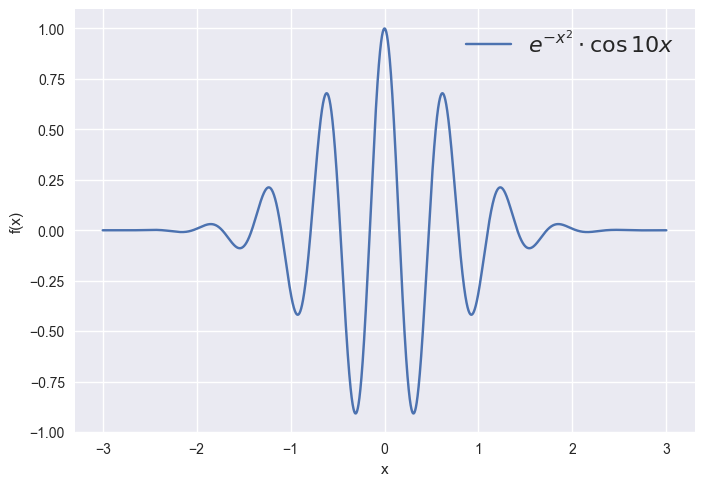

In [142]:
x_plot = torch.linspace(start=x_min, end=x_max, steps=10000)
y_plot = f(x_plot)

plt.plot(x_plot, y_plot, label=r"$e^{-x^2} \cdot \cos{10x}$")
plt.ylabel("f(x)")
plt.xlabel("x")
plt.legend(fontsize=16, loc="upper right")
plt.show()

### 1.3. Предобработка данных

In [143]:
scaler_x = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

x_train_scaled = torch.FloatTensor(scaler_x.fit_transform(x_train))
x_val_scaled = torch.FloatTensor(scaler_x.transform(x_val))
x_test_scaled = torch.FloatTensor(scaler_x.transform(x_test))
y_train_scaled = torch.FloatTensor(scaler_y.fit_transform(y_train))
y_val_scaled = torch.FloatTensor(scaler_y.transform(y_val))
y_test_scaled = torch.FloatTensor(scaler_y.transform(y_test))

batch_size = 1

train_scaled_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_scaled, y_train_scaled),
    batch_size=batch_size,
    shuffle=True,
)
val_scaled_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_val_scaled, y_val_scaled),
    batch_size=batch_size,
    shuffle=True,
)
test_scaled_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_scaled, y_test_scaled),
    batch_size=batch_size,
    shuffle=True,
)

## 2. Обучение и тестирование нейронной сети с одним скрытым слоем 

### 2.1. Архитектура нейронной сети

In [144]:
class One_Hid_Net(torch.nn.Module):
    def __init__(self, n_neurons, hid_act=nn.Tanh()):
        super().__init__()

        self.fc1 = nn.Linear(1, n_neurons)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        nn.init.normal_(self.fc1.bias, mean=0.0, std=0.1)
        self.act1 = hid_act

        self.fc2 = nn.Linear(n_neurons, 1)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0.0, std=0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

    def get_hidden_output(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        return x

### 2.2. Обучение нейронной сети

#### 2.2.1. Определение функций обучения

Я выбрал критерий останова `ранний останов`. Этот метод заключается в том, чтобы остановить обучение тогда, когда на валидационных данных функция потерь начнет закономерно расти (например, `patience=10` раз подряд). Тогда останавливаемся, откатываем веса обратно и считаем, что сеть обучена.

In [145]:
class EarlyStopping:
    def __init__(self, patience=10):
        self.stopping_flag = False
        self.patience = patience
        self.best_loss = float("inf")
        self.trigger_times = 0

    def __call__(self, current_loss):
        # ошибка уменьшилась - сбрасываем счетчик
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.trigger_times = 0
            return 0

        # ошибка как минимум на том же уровне - увеличиваем счетчик и, если patience превышен, совершаем останов
        else:
            self.trigger_times += 1
            if self.trigger_times < self.patience:
                return 1
            else:
                self.stopping_flag = True
                return 2

In [146]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    epoch_losses = []
    model.train()
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_losses.append(loss.item())

    return sum(epoch_losses) / len(epoch_losses)

In [147]:
def validate(model, val_loader, criterion):
    val_losses = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            loss = criterion(y_batch, y_pred)
            val_losses.append(loss.item())
    return sum(val_losses) / len(val_losses)

In [148]:
def test(model, test_loader, criterion):
    test_losses = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            y_pred = model(x_batch)
            loss = criterion(y_batch, y_pred)
            test_losses.append(loss.item())
    return sum(test_losses) / len(test_losses)

Формируем DataFrame различных зависимостей от такта обучения (потерей на разных данных и параметров модели), чтобы потом просто построить графики:

In [149]:
def train_result_parse(train_losses, val_losses, test_losses, weight_list):
    df = pd.DataFrame(
        {
            r"$E_{train}(\tau)$": train_losses,
            r"$E_{val}(\tau)$": val_losses,
            r"$E_{test}(\tau)$": test_losses,
        },
        index=range(0, len(train_losses)),
    )

    with torch.no_grad():
        for tau, model_parameters in enumerate(weight_list):
            weights_fc1, bias_fc1, weights_fc2, bias_fc2 = model_parameters
            for i, weight in enumerate(weights_fc1.flatten(), start=1):
                df.loc[tau, f"$w_{{{i}1}}^1(\\tau)$"] = weight.item()
            for i, bias in enumerate(bias_fc1, start=1):
                df.loc[tau, f"$b_{{{i}}}^1(\\tau)$"] = bias.item()
            for i, weight in enumerate(weights_fc2.flatten(), start=1):
                df.loc[tau, f"$w_{{1{i}}}^2(\\tau)$"] = weight.item()
            for i, bias in enumerate(bias_fc2, start=1):
                df.loc[tau, f"$b_{{{i}}}^2(\\tau)$"] = bias.item()
    return df

In [150]:
def train(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    max_epochs,
    patience,
):
    stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []
    test_losses = []
    weight_list = []

    # записываем начальные параметры модели
    best_model = {
        name: param.clone().detach()  # клонируем и отключаем граф вычислений
        for name, param in model.state_dict().items()
    }

    for epoch in tqdm(range(max_epochs), desc=f"Epochs"):
        # записываем различные потери по ходу обучения
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)

        val_loss = validate(model, val_loader, criterion)
        val_losses.append(val_loss)

        test_loss = test(model, test_loader, criterion)
        test_losses.append(test_loss)

        weights = [params.clone().detach() for params in model.parameters()]
        weight_list.append(weights)

        stopping_signal = stopping(val_loss)
        if stopping_signal == 2:
            print(f"Early stopping at epoch {epoch}")
            break
        elif stopping_signal == 0:
            best_model = {
                name: param.clone().detach()  # клонируем и отключаем граф вычислений
                for name, param in model.state_dict().items()
            }

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
            )

    # восстанавливаем лучшие параметры у модели
    model.load_state_dict(best_model)

    # откатываем потери в момент, когда параметры модели были лучшими
    train_losses = train_losses[: -stopping.trigger_times]
    val_losses = val_losses[: -stopping.trigger_times]
    test_losses = test_losses[: -stopping.trigger_times]
    weight_list = weight_list[: -stopping.trigger_times]

    # парсим результаты в DataFrame
    parse_result = train_result_parse(
        train_losses, val_losses, test_losses, weight_list
    )

    return model, parse_result

#### 2.2.2. Обучение нейронной сети

In [151]:
# задаем гиперпараметры и создаем модель
n_neurons = 5
learning_rate = 0.001
max_epochs = 1000
patience = 50
model = One_Hid_Net(n_neurons)

# для графиков
x_plot_scaled = torch.FloatTensor(scaler_x.transform(x_plot.unsqueeze(1)))

with torch.no_grad():
    y_hid_before = model.get_hidden_output(x_plot_scaled)
    y_before_scaled = model(x_plot_scaled)
y_before = scaler_y.inverse_transform(y_before_scaled)

# функция ошибки и метод обучения
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# обучение НС
model, results = train(
    model,
    train_scaled_loader,
    val_scaled_loader,
    test_scaled_loader,
    criterion,
    optimizer,
    max_epochs,
    patience,
)

# для графиков
with torch.no_grad():
    y_hid_after = model.get_hidden_output(x_plot_scaled)
    y_after_scaled = model(x_plot_scaled)
y_after = scaler_y.inverse_transform(y_after_scaled)

Epochs:   1%|          | 11/1000 [00:00<00:19, 49.84it/s]

Epoch 0, Train Loss: 0.5036, Val Loss: 0.4102


Epochs:   6%|▌         | 58/1000 [00:01<00:18, 49.88it/s]

Epoch 50, Train Loss: 0.1157, Val Loss: 0.0875


Epochs:   8%|▊         | 81/1000 [00:01<00:18, 49.20it/s]

Early stopping at epoch 81


#### 2.2.3. Схема нейронной сети

In [152]:
# схема нейронной сети
graph = draw_graph(model, input_data=torch.zeros(size=(1, 1)))
graph.visual_graph.render(
    filename="one_hid_scheme", directory="img", view=True, format="png"
)

'img/one_hid_scheme.png'

### 2.3. Тестирование нейронной сети

#### 2.3.1. График зависимости выхода $y(x)$ сети от входа

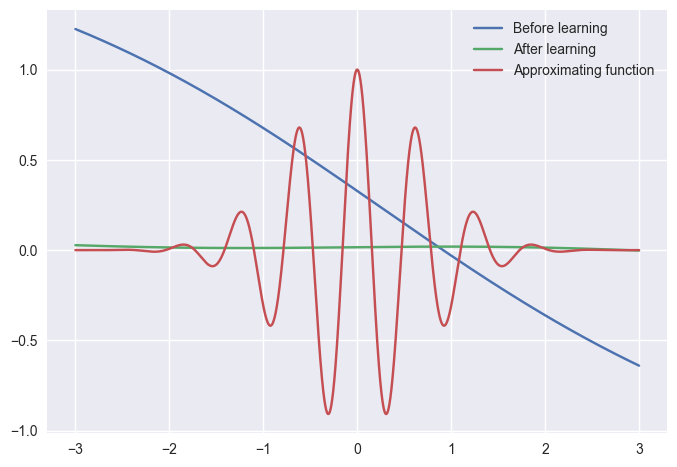

In [153]:
# график до обучения
plt.plot(x_plot, y_before, label="Before learning")

# график после обучения
plt.plot(x_plot, y_after, label="After learning")

# график аппроксимируемой функции
plt.plot(x_plot, y_plot, label="Approximating function")

plt.legend()
plt.show()

#### 2.3.2. Графики зависимостей выходов $y_k(x)$ нейронов скрытого слоя от входа

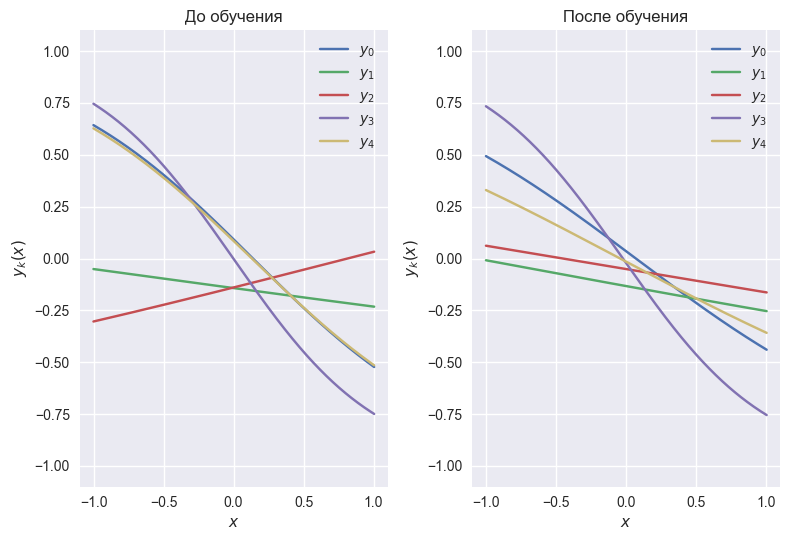

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2)

for i in range(n_neurons):
    ax1.plot(x_plot_scaled, y_hid_before[:, i], label=f"$y_{i}$")
ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y_k(x)$")
ax1.set_title("До обучения")
ax1.legend()

for i in range(n_neurons):
    ax2.plot(x_plot_scaled, y_hid_after[:, i], label=f"$y_{i}$")
ax2.set_xlim(-1.1, 1.1)
ax2.set_ylim(-1.1, 1.1)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y_k(x)$")
ax2.set_title("После обучения")
ax2.legend()

plt.tight_layout()
plt.show()

#### 2.3.3. Графики зависимостей ошибки сети $E(\tau)$

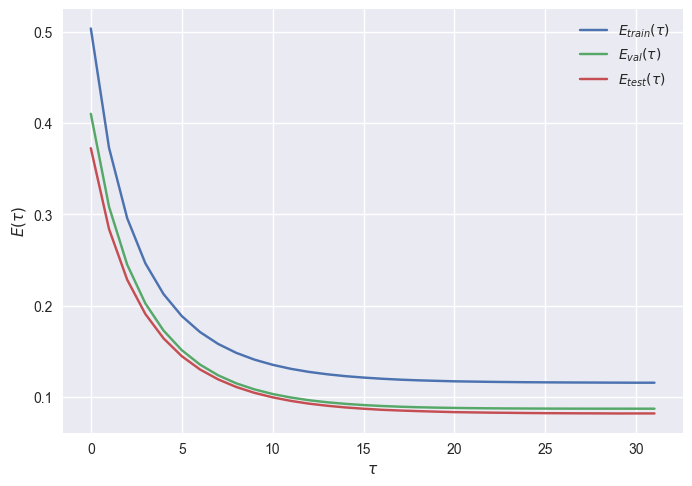

In [155]:
columns = [col for col in results.columns if col.startswith("$E_")]
for col in columns:
    plt.plot(results.index, results[col], label=col)
plt.xlabel(r"$\tau$")
plt.ylabel(r"$E(\tau)$")
plt.legend()
plt.show()

#### 2.3.4. Графики зависимостей синаптических коэффициентов сети $w(\tau)$

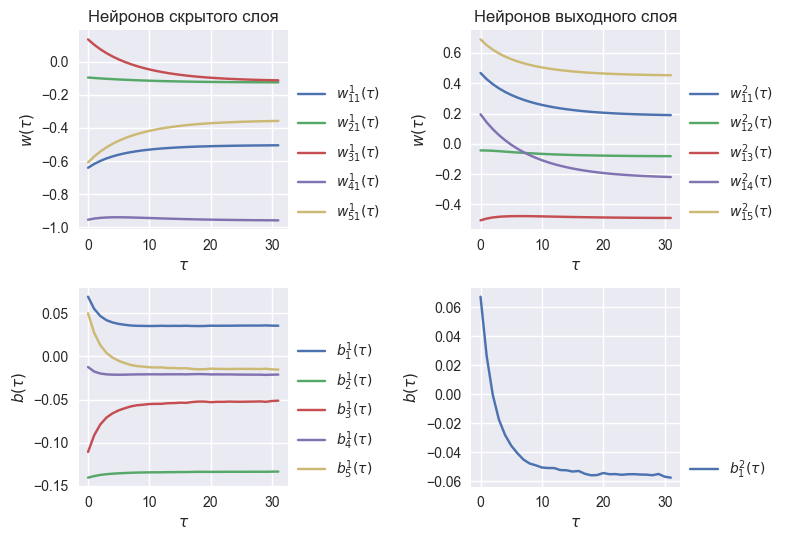

In [156]:
fig, ax = plt.subplots(2, 2)

columns = [
    col
    for col in results.columns
    if col.startswith("$w") and col.endswith("^1(\\tau)$")
]
for col in columns:
    ax[0, 0].plot(results.index, results[col], label=col)
ax[0, 0].legend(loc=(1.02, 0))
ax[0, 0].set_xlabel(r"$\tau$")
ax[0, 0].set_ylabel(r"$w(\tau)$")

columns = [
    col
    for col in results.columns
    if col.startswith("$b") and col.endswith("^1(\\tau)$")
]
for col in columns:
    ax[1, 0].plot(results.index, results[col], label=col)
ax[1, 0].legend(loc=(1.02, 0))
ax[1, 0].set_xlabel(r"$\tau$")
ax[1, 0].set_ylabel(r"$b(\tau)$")

columns = [
    col
    for col in results.columns
    if col.startswith("$w") and col.endswith("^2(\\tau)$")
]
for col in columns:
    ax[0, 1].plot(results.index, results[col], label=col)
ax[0, 1].legend(loc=(1.02, 0))
ax[0, 1].set_xlabel(r"$\tau$")
ax[0, 1].set_ylabel(r"$w(\tau)$")

columns = [
    col
    for col in results.columns
    if col.startswith("$b") and col.endswith("^2(\\tau)$")
]
for col in columns:
    ax[1, 1].plot(results.index, results[col], label=col)
ax[1, 1].legend(loc=(1.02, 0))
ax[1, 1].set_xlabel(r"$\tau$")
ax[1, 1].set_ylabel(r"$b(\tau)$")

ax[0, 0].set_title("Нейронов скрытого слоя")
ax[0, 1].set_title("Нейронов выходного слоя")

plt.tight_layout()
plt.show()

#### 2.3.5 Показатели качества обученной нейросетевой модели

In [157]:
with torch.no_grad():
    y_train_pred = scaler_y.inverse_transform(model(x_train_scaled))
    y_val_pred = scaler_y.inverse_transform(model(x_val_scaled))
    y_test_pred = scaler_y.inverse_transform(model(x_test_scaled))

train_max_abs_error = max_error(y_train, y_train_pred)
val_max_abs_error = max_error(y_val, y_val_pred)
test_max_abs_error = max_error(y_test, y_test_pred)

train_MSE = mean_squared_error(y_train, y_train_pred)
val_MSE = mean_squared_error(y_val, y_val_pred)
test_MSE = mean_squared_error(y_test, y_test_pred)

train_RMSE = train_MSE**0.5
val_RMSE = val_MSE**0.5
test_RMSE = test_MSE**0.5

quality = pd.DataFrame(
    {
        "Обучающая": [train_max_abs_error, train_MSE, train_RMSE],
        "Валидационная": [val_max_abs_error, val_MSE, val_RMSE],
        "Тестовая": [test_max_abs_error, test_MSE, test_RMSE],
    },
    index=["Макс. абс. ошибка", "С.К.О.", "RMSE"],
)
quality

,Обучающая,Валидационная,Тестовая
Макс. абс. ошибка,0.946550,0.932404,0.659771
С.К.О.,0.099972,0.075654,0.071152
RMSE,0.316184,0.275053,0.266744


## 3. Улучшение качества аппроксимации

In [158]:
train_scaled_loader_new = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train_scaled, y_train_scaled),
    batch_size=len(x_train_scaled),
    shuffle=True,
)
val_scaled_loader_new = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_val_scaled, y_val_scaled),
    batch_size=len(x_val_scaled),
    shuffle=True,
)
test_scaled_loader_new = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_scaled, y_test_scaled),
    batch_size=len(x_test_scaled),
    shuffle=True,
)

In [159]:
# задаем гиперпараметры и создаем модель
n_neurons_new = 5
learning_rate_new = 0.01
max_epochs_new = 1000
patience_new = 50
model_new = One_Hid_Net(n_neurons_new, nn.Tanh())

# функция ошибки и метод обучения
optimizer_new = optim.SGD(model_new.parameters(), lr=learning_rate_new)

# обучение НС
model, results = train(
    model_new,
    train_scaled_loader_new,
    val_scaled_loader_new,
    test_scaled_loader_new,
    criterion,
    optimizer_new,
    max_epochs_new,
    patience_new,
)

with torch.no_grad():
    y_train_pred_new = scaler_y.inverse_transform(model_new(x_train_scaled))
    y_val_pred_new = scaler_y.inverse_transform(model_new(x_val_scaled))
    y_test_pred_new = scaler_y.inverse_transform(model_new(x_test_scaled))

train_max_abs_error_new = max_error(y_train, y_train_pred_new)
val_max_abs_error_new = max_error(y_val, y_val_pred_new)
test_max_abs_error_new = max_error(y_test, y_test_pred_new)

train_MSE_new = mean_squared_error(y_train, y_train_pred_new)
val_MSE_new = mean_squared_error(y_val, y_val_pred_new)
test_MSE_new = mean_squared_error(y_test, y_test_pred_new)

train_RMSE_new = train_MSE_new**0.5
val_RMSE_new = val_MSE_new**0.5
test_RMSE_new = test_MSE_new**0.5

quality_new = pd.DataFrame(
    {
        "Обучающая": [train_max_abs_error_new, train_MSE_new, train_RMSE_new],
        "Валидационная": [val_max_abs_error_new, val_MSE_new, val_RMSE_new],
        "Тестовая": [test_max_abs_error_new, test_MSE_new, test_RMSE_new],
    },
    index=["Макс. абс. ошибка", "С.К.О.", "RMSE"],
)
quality_new

Epochs:  16%|█▌        | 161/1000 [00:00<00:00, 857.02it/s]

Epoch 0, Train Loss: 0.4464, Val Loss: 0.4228
Epoch 50, Train Loss: 0.1451, Val Loss: 0.1150
Epoch 100, Train Loss: 0.1184, Val Loss: 0.0897
Epoch 150, Train Loss: 0.1158, Val Loss: 0.0879


Epochs:  21%|██        | 212/1000 [00:00<00:00, 857.11it/s]


Epoch 200, Train Loss: 0.1155, Val Loss: 0.0879
Early stopping at epoch 212


,Обучающая,Валидационная,Тестовая
Макс. абс. ошибка,0.945734,0.931685,0.646865
С.К.О.,0.100151,0.076105,0.070993
RMSE,0.316466,0.275871,0.266445
